
<h1 style="text-align:center;"> Classification, scores and confusion distribution </h1>

In order to easily remember how to do classification in Python (at least using `scikit-learn`) 
I put here some of the examples given in the webpage of [Scikit-learn](http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html).

And a few examples for how to score the results.

# Import required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
from ggplot import *
import seaborn as sns
# sns.set_style("whitegrid")

np.random.seed(0)
%matplotlib inline

# Generate data for classification

`Scikit-learn` has a nice function to generate artificial data (namely `sklearn.datasets.make_classification`).

In [2]:

# generate skwed data (the ratio of class 1 to class 0 is defined by weights)
X, y = datasets.make_classification(n_samples=30000, n_features=10,
                                    n_informative=2, n_redundant=2,
                                    weights = [0.7]
                                    )
# use 60% of the data for training
train_ratio = 0.6
train_samples = int(len(y) * train_ratio)

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create a DataFrame about few statistics of the data generated for only illustration purpose  
counts = pd.DataFrame(columns=["nrows", "ncols", "nrows_C0", "nrows_C1", "C0 ratio", "C1 ratio"],
                      index=["data", "training", "testing"])
counts.loc["data",] = [X.shape[0], X.shape[1], 
                       sum(y==0), sum(y==1), 
                       1.*sum(y==0)/len(y), 1.*sum(y==1)/len(y)]
counts.loc["training",] = [X_train.shape[0], X_train.shape[1], 
                           sum(y_train==0), sum(y_train==1), 
                           1.*sum(y_train==0)/len(y_train), 1.*sum(y_train==1)/len(y_train)]
counts.loc["testing",] = [X_test.shape[0], X_test.shape[1], 
                          sum(y_test==0), sum(y_test==1), 
                          1.*sum(y_test==0)/len(y_test), 1.*sum(y_test==1)/len(y_test)]

counts

,nrows,ncols,nrows_C0,nrows_C1,C0 ratio,C1 ratio
data,30000,10,20956,9044,0.6985333,0.3014667
training,18000,10,12545,5455,0.6969444,0.3030556
testing,12000,10,8411,3589,0.7009167,0.2990833


# 2. Classification using scikit-learn

Now lets start training the models.

I have just taken the same models as it was in the example given [here](http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html).

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import time
start_time = time.time()

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)

# DataFrame for prediction probabilities 
probs_df = pd.DataFrame(columns=["Logistic",
                                "Naive Bayes",
                                'Support Vector Classification',
                                'Random Forest'])

# DataFrame for score
score_df = pd.DataFrame(columns=["Logistic",
                                "Naive Bayes",
                                'Support Vector Classification',
                                'Random Forest'],
                      index=["Accuracy", "auc", "log score", "PPV", "TPR", "F1Measure"])
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    # fit a model
    clf.fit(X_train, y_train)
    
    # predict 
    predicted = clf.predict(X_test)
    
    # obtaion probabilities
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        probs = np.array([1-prob_pos,prob_pos]).T
    
    # probabilities for class 1
    probs_df[name] = probs[:,1]
    
    # calculate few scores for the predictions
    score_df[name] = pd.DataFrame([metrics.accuracy_score(y_test, predicted),
                                  metrics.roc_auc_score(y_test, probs[:,1]),
                                  1-metrics.log_loss(y_test, probs),
                                  metrics.precision_score(y_test, predicted),
                                  metrics.recall_score(y_test, predicted),
                                  metrics.f1_score(y_test, predicted)], 
                                  index=["Accuracy", "auc", "log score", "PPV", "TPR", "F1Measure"])
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.69877314568 seconds ---


# Scores for each model

In [4]:
score_df

,Logistic,Naive Bayes,Support Vector Classification,Random Forest
Accuracy,0.925583,0.919833,0.926333,0.935583
auc,0.970856,0.967455,0.970889,0.973768
log score,0.802073,0.776394,0.493274,0.730091
PPV,0.876326,0.838793,0.874758,0.885331
TPR,0.874617,0.906102,0.879632,0.901365
F1Measure,0.875471,0.871149,0.877188,0.893276


# Scores - more illustrative way

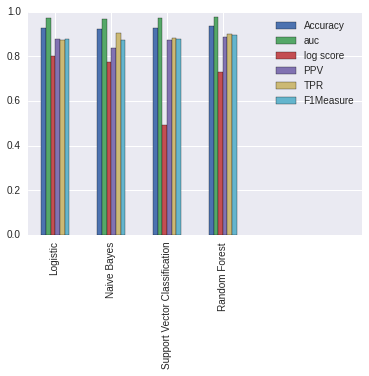

In [5]:
ax = score_df.T.plot(kind="bar", xlim=[-0.5,5.5])

# Feel the results of the models' prediction

I like the following plots very much. The let you feel what really did your models.

The plot are inspired by the equivalent (more or less -- I couldn't do better;) ) R code from [joyofdata](https://github.com/joyofdata/joyofdata-articles/blob/master/roc-auc/plot_pred_type_distribution.R)

What is important in these plots to observe is to look at the plots and the distribution of the prediction and comparing it with the measure shown above.

It is clear that at least for this case (e.g. when data is skewed regarding classes i.e. 70% 0s and 30% 1s) `accuracy` alone is not a good measure.

If we rank the model based on their `accuracy`, SVM would be the second. But from the plot blow it is clear that it is not the case. It seems that `log-score` represent better the goodness of the classification based on what we can observe obtically in the plots shown below.

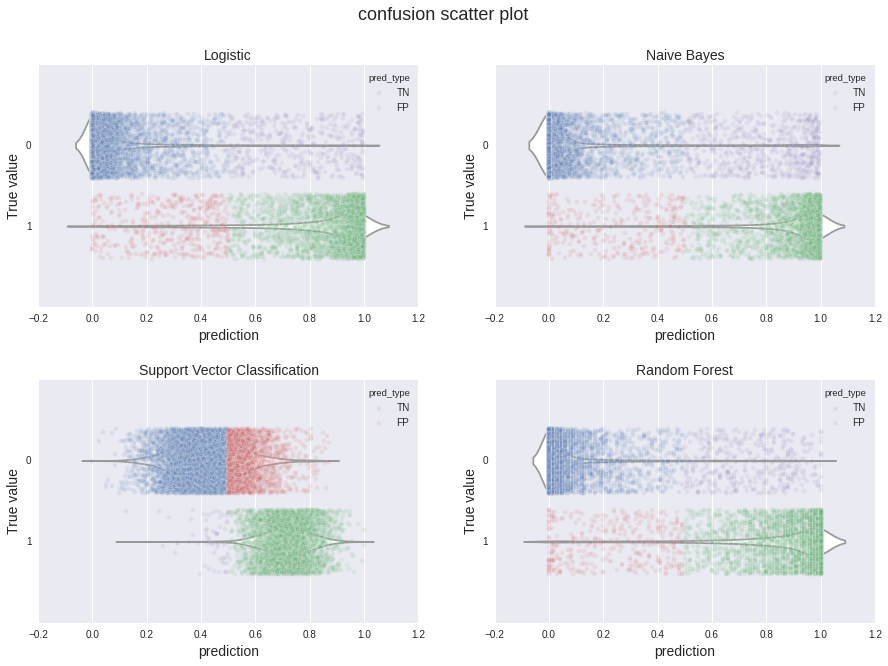

In [6]:

def plot_pred_type_distribution(prob_pos, true_value, threshold, title="", ax=None):
    """ Plot confusion scatter 
    
        --  The code is inspired by :
            The joyofdata: 
            https://github.com/joyofdata/joyofdata-articles/blob/master/roc-auc/plot_pred_type_distribution.R
    """
    
    df = pd.DataFrame(columns=["prob_pos", "true_value", "pred_type"])
    df.prob_pos = prob_pos
    df.true_value = true_value

    df.loc[(df.prob_pos >= threshold) & (df.true_value == 1),"pred_type"] = "TP"
    df.loc[(df.prob_pos >= threshold) & (df.true_value == 0),"pred_type"] = "FP" 
    df.loc[(df.prob_pos <  threshold) & (df.true_value == 1),"pred_type"] = "FN" 
    df.loc[(df.prob_pos <  threshold) & (df.true_value == 0),"pred_type"] = "TN"
  
    ax = sns.stripplot(x="prob_pos", y="true_value", data=df, size=5,
                       orient="h", hue="pred_type", split= False, 
                       jitter=0.4, ax=ax, alpha=0.1)
    ax = sns.violinplot(x="prob_pos", y="true_value", data=df, inner=None, 
                        color='#FFFFFF', orient="h", scale="count", ax=ax)
    ax.set_ylim(2,-1)
    ax.set_title(title, size=14)
    ax.set_xlabel("prediction", size=14)
    ax.set_ylabel("True value", size=14)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.3)

plot_pred_type_distribution(probs_df["Logistic"], y_test, 0.5, "Logistic" , ax = ax1)
plot_pred_type_distribution(probs_df["Naive Bayes"], y_test, 0.5, "Naive Bayes", ax = ax2)
plot_pred_type_distribution(probs_df["Support Vector Classification"], y_test, 0.5, "Support Vector Classification", ax=ax3)
plot_pred_type_distribution(probs_df["Random Forest"], y_test, 0.5, "Random Forest", ax=ax4)
txt = fig.suptitle("confusion scatter plot", size=18)